In [66]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV,cross_val_score
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [67]:
df = pd.read_excel('premiums_with_life_style_project.xlsx')
df.head(3)

,Age,Gender,Region,Marital_status,Physical_Activity,Stress_Level,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [68]:
df.shape

(10000, 15)

In [69]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.head(3)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [70]:
df.isna().sum()

age                       0
gender                    0
region                    0
marital_status            0
physical_activity         0
stress_level              0
number_of_dependants      0
bmi_category              0
smoking_status            9
employment_status         7
income_level             18
income_lakhs              0
medical_history           0
insurance_plan            0
annual_premium_amount     0
dtype: int64

In [71]:
df.dropna(inplace=True)
df.isna().sum()

age                      0
gender                   0
region                   0
marital_status           0
physical_activity        0
stress_level             0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64

In [72]:
df.duplicated().sum()

np.int64(0)

In [73]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [74]:
df.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,9973.000000,9973.000000,9973.000000,9973.000000
mean,41.319362,3.195628,23.382232,19503.816705
std,58.044687,21.679565,32.334811,8898.079736
min,18.000000,0.000000,1.000000,3582.000000
25%,24.000000,0.000000,6.000000,11774.000000
50%,37.000000,2.000000,16.000000,19314.000000
75%,50.000000,3.000000,31.000000,26500.000000
max,1178.000000,456.000000,960.000000,45854.000000


In [75]:
numeric_column = df.select_dtypes(include=['float64','int64']).columns
numeric_column

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

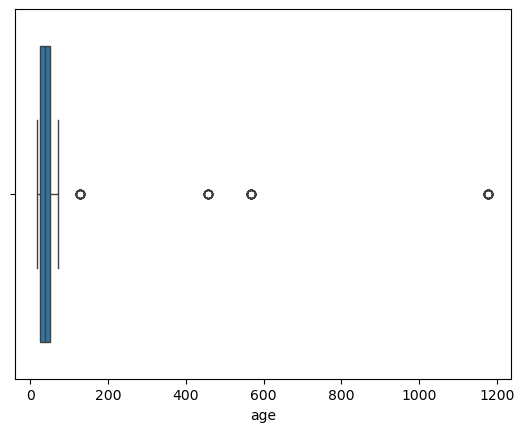

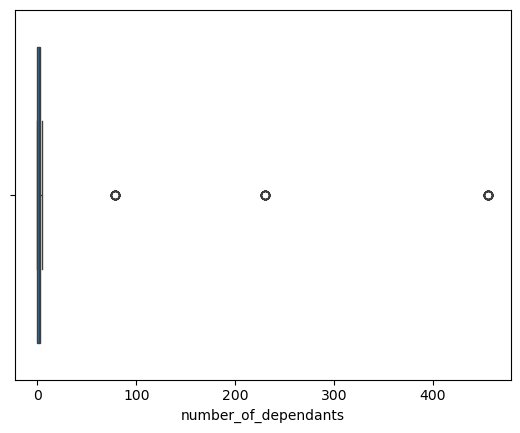

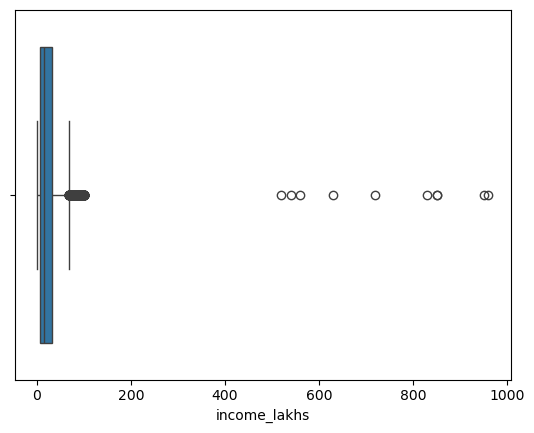

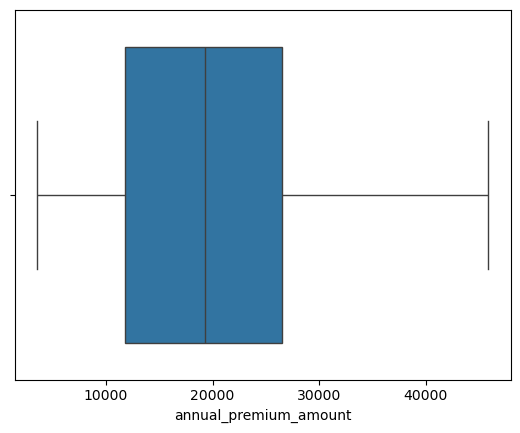

In [76]:

for col in numeric_column:
      sns.boxplot(x=df[col])
      plt.show()

In [77]:
df[df['age'] > 100]['age'].unique()


array([ 128, 1178,  567,  456])

In [78]:
df1 = df[df['age'] <= 100].copy()
df1.age.describe()

count    9915.000000
mean       37.743621
std        13.975462
min        18.000000
25%        24.000000
50%        37.000000
75%        50.000000
max        72.000000
Name: age, dtype: float64

In [79]:
def get_iqr_bounds(col):
      Q1,Q3 = col.quantile([0.25, .75])
      IQR = Q3-Q1
      lower_bound = Q1-1.5*IQR
      upper_bound = Q3+1.5*IQR
      return lower_bound,upper_bound
lower, upper = get_iqr_bounds(df['income_lakhs'])
lower , upper
df1[df1['income_lakhs'] < upper].shape


(9218, 15)

In [80]:
type(df1)


pandas.core.frame.DataFrame

In [81]:
quantile_threshold = df1.income_lakhs.quantile(0.999)
df1[df1['income_lakhs'] > quantile_threshold].shape


(10, 15)

In [82]:
df2 = df1[df1.income_lakhs<=quantile_threshold].copy()
df2.shape

(9905, 15)

### Outlier Treatment: Dependants

In [83]:
df2.number_of_dependants.describe()

count    9905.000000
mean        3.205553
std        21.753158
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max       456.000000
Name: number_of_dependants, dtype: float64

<Axes: xlabel='number_of_dependants', ylabel='Count'>

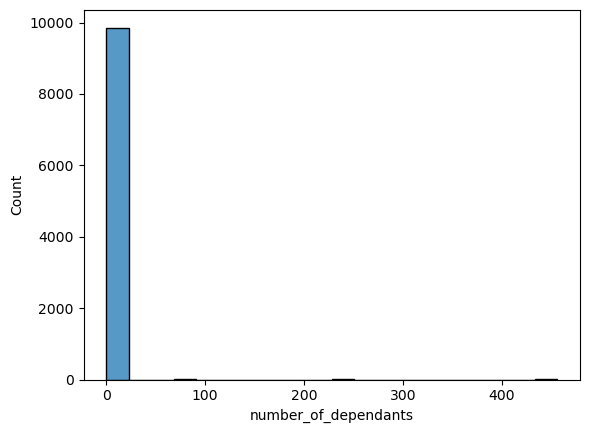

In [84]:
sns.histplot(x=df2['number_of_dependants'], bins=20)

In [85]:
quantile_threshold1 = df2.number_of_dependants.quantile(0.99)
quantile_threshold1
df3 = df2[df2.number_of_dependants  <= quantile_threshold1].copy()
df3.number_of_dependants.describe()

count    9858.000000
mean        1.919963
std         1.503027
min         0.000000
25%         0.000000
50%         2.000000
75%         3.000000
max         5.000000
Name: number_of_dependants, dtype: float64

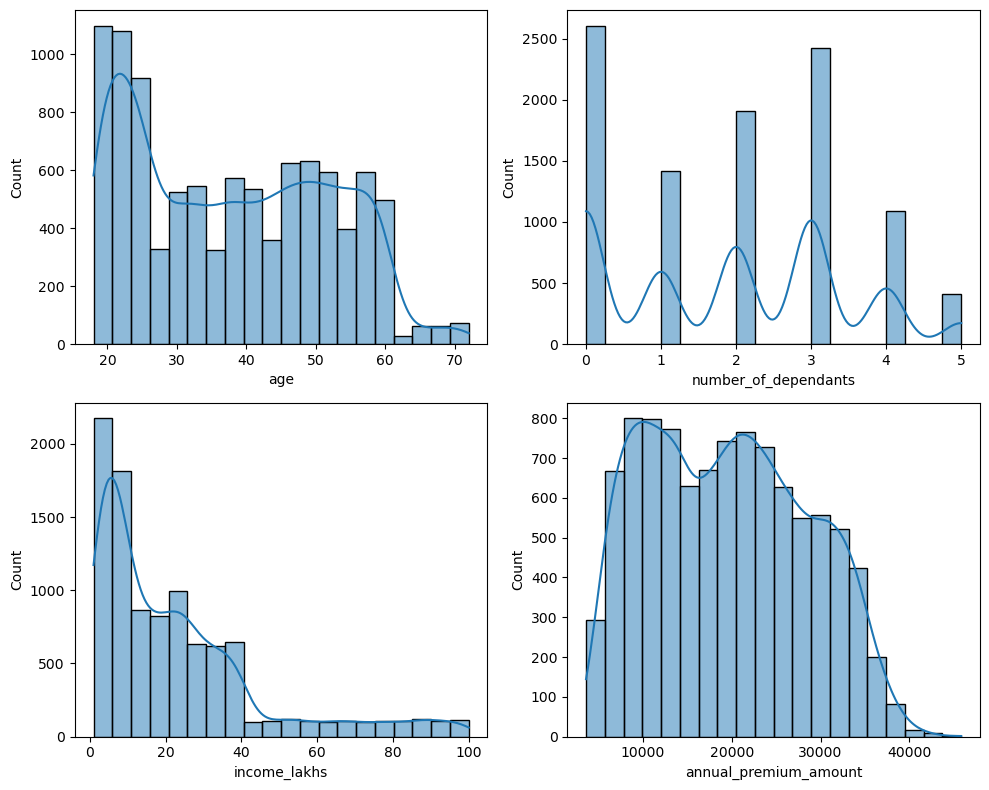

In [86]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axs = axs.flatten()   # convert 2x2 grid into 1D array

for i, col in enumerate(numeric_column):
    sns.histplot(x=df3[col], bins=20, kde=True, ax=axs[i])

plt.tight_layout()
plt.show()

In [87]:
df.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


### Bivariate Analysis: Numeric Columns

In [88]:
numeric_column

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

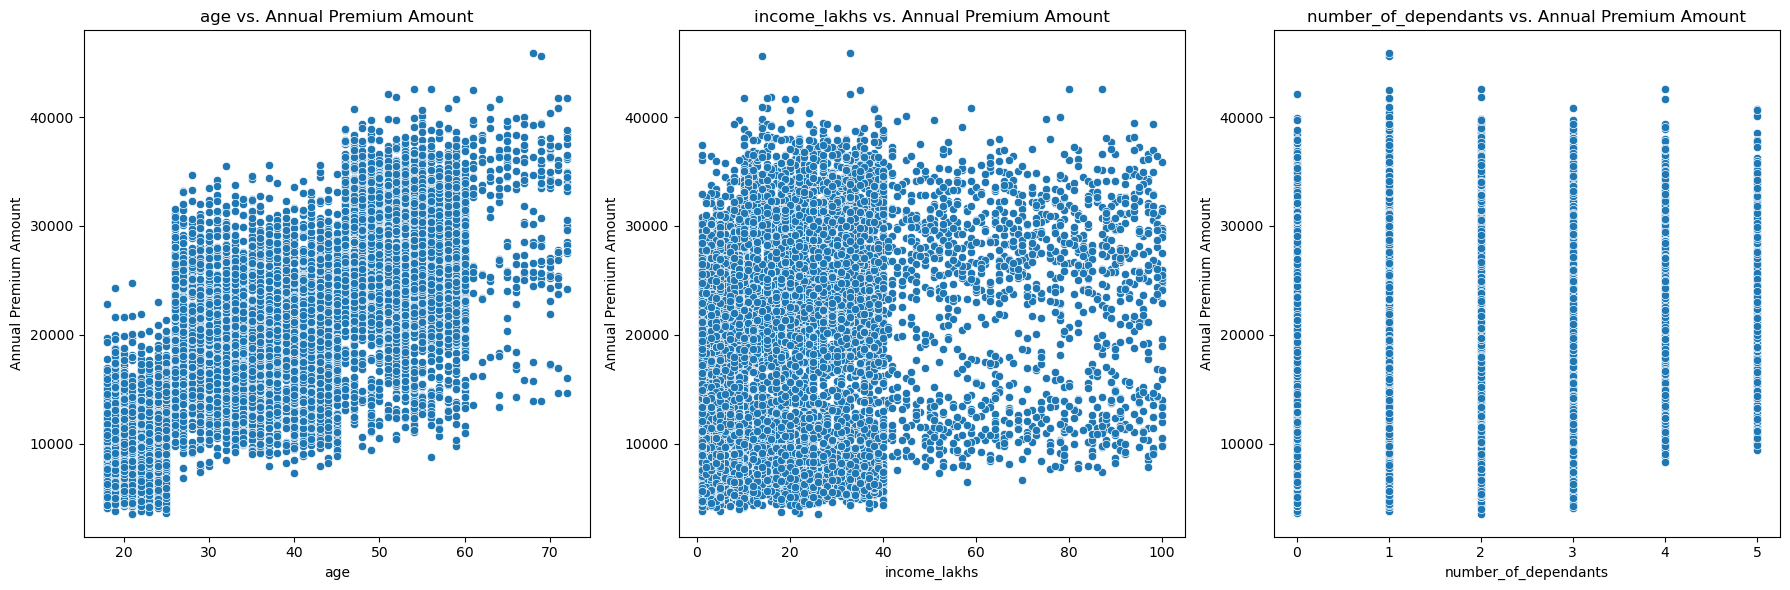

In [89]:
numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

fig, axes = plt.subplots(1, len(numeric_features), figsize=(18, 6))  # Adjust figure size as necessary

for ax, column in zip(axes, numeric_features):
    sns.scatterplot(x=df3[column], y=df3['annual_premium_amount'], ax=ax)
    ax.set_title(f'{column} vs. Annual Premium Amount')
    ax.set_xlabel(column)
    ax.set_ylabel('Annual Premium Amount')

plt.tight_layout()  # Adjust layout
plt.show()

In [90]:
df3.head(3)

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459


In [91]:
categorical_cols = ['gender', 'region', 'marital_status', 'physical_activity', 'stress_level', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'medical_history', 'insurance_plan']
for col in categorical_cols:
    print(col, ":", df3[col].unique())

gender : ['Female' 'Male']
region : ['Southeast' 'Northeast' 'Southwest' 'Northwest']
marital_status : ['Unmarried' 'Married']
physical_activity : ['Medium' 'Low' 'High']
stress_level : ['Medium' 'High' 'Low']
bmi_category : ['Normal' 'Overweight' 'Obesity' 'Underweight']
smoking_status : ['No Smoking' 'Occasional' 'Regular']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['25L - 40L' '10L - 25L' '<10L' '> 40L']
medical_history : ['High blood pressure' 'No Disease' 'Thyroid'
 'High blood pressure & Heart disease' 'Diabetes & Thyroid' 'Diabetes'
 'Heart disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease']
insurance_plan : ['Gold' 'Silver' 'Bronze']


In [92]:
pct_count = df['gender'].value_counts(normalize=True)*100
pct_count


gender
Female    59.911762
Male      40.088238
Name: proportion, dtype: float64

<Axes: xlabel='gender', ylabel='proportion'>

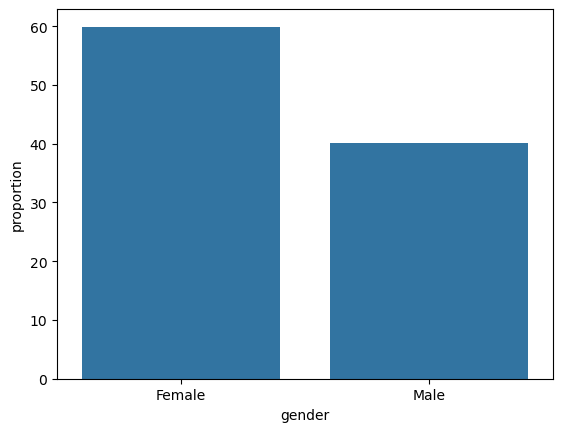

In [93]:
sns.barplot(x=pct_count.index, y=pct_count)

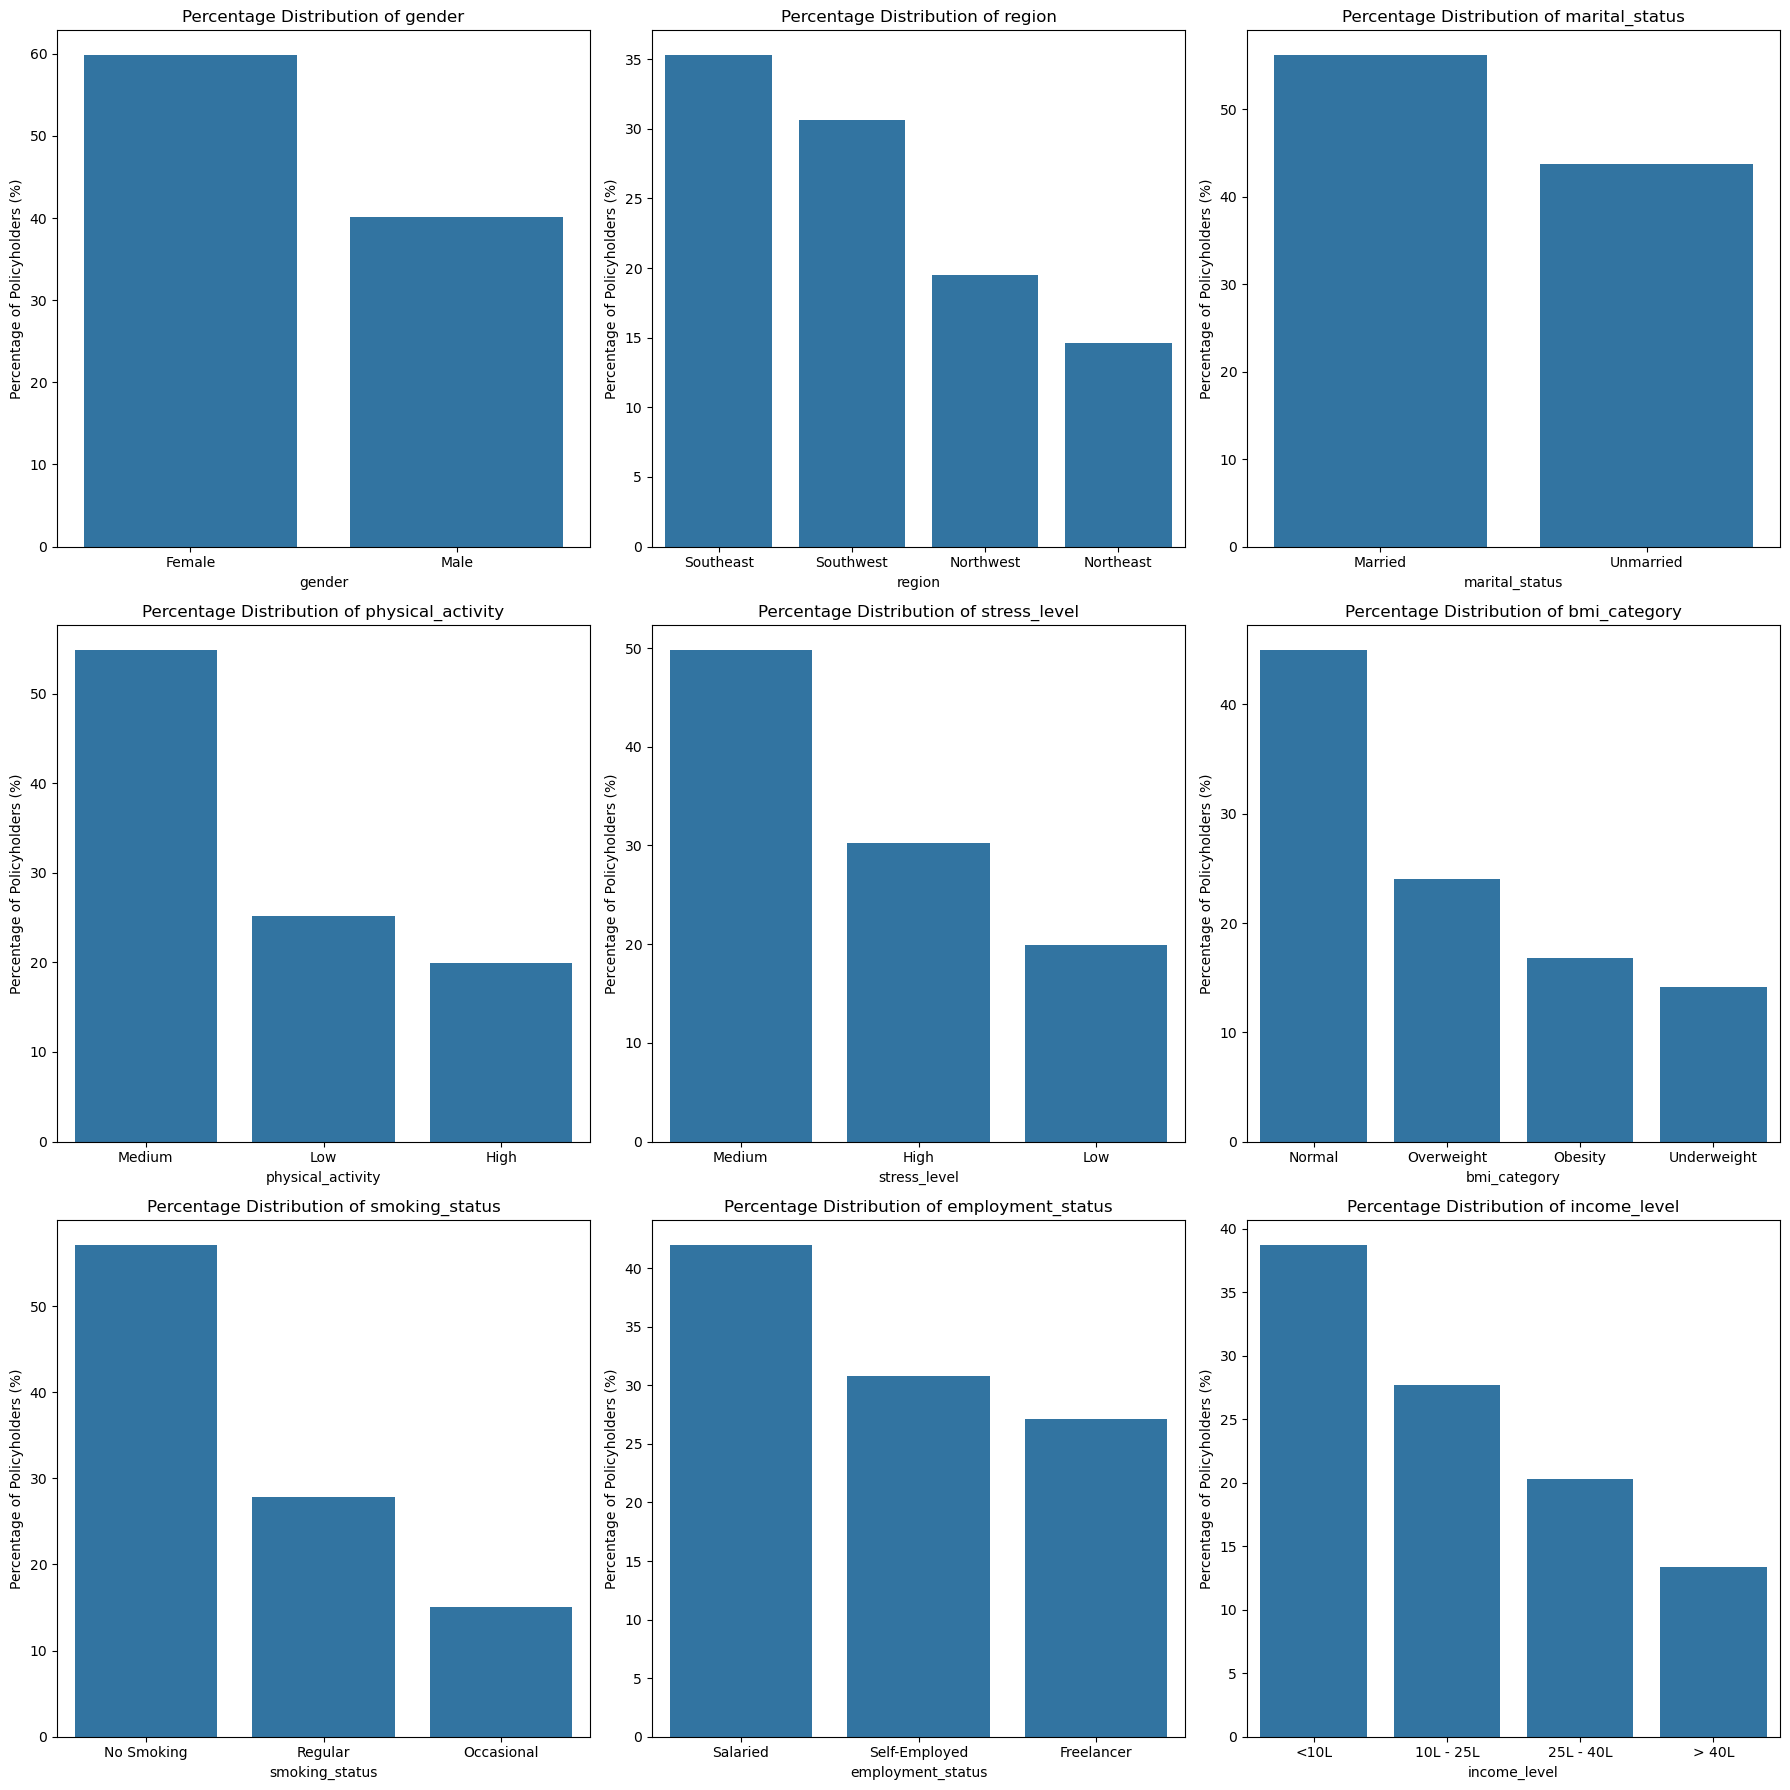

In [94]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # Adjust figure size as necessary
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, column in zip(axes, categorical_cols):
    # Calculate the percentage distribution of each category
    category_counts = df3[column].value_counts(normalize=True) * 100  # normalize=True gives the relative frequencies
    
    # Plotting the distribution using barplot
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f'Percentage Distribution of {column}')
    ax.set_ylabel('Percentage of Policyholders (%)')
    ax.set_xlabel(column)  # Set xlabel to the column name for clarity

plt.tight_layout()  # Adjusts plot parameters for better fit in the figure window
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L          822   909     998
25L - 40L          533   733     733
<10L              2266   184    1366
> 40L               55   788     471


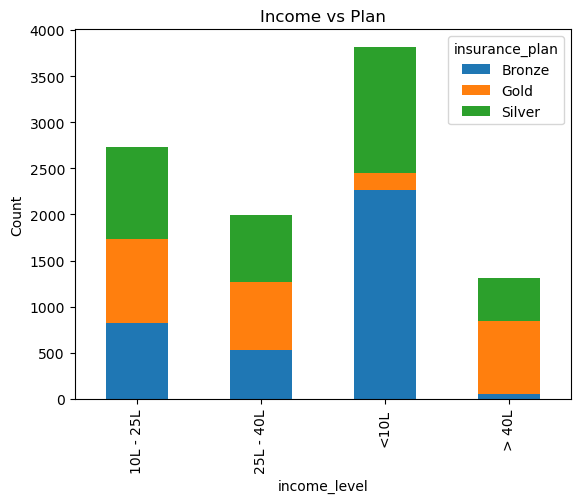

In [95]:
crosstab = pd.crosstab(df3['income_level'], df3['insurance_plan'])
print(crosstab)
crosstab.plot(kind='bar', stacked=True)
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.show()

<Axes: xlabel='insurance_plan', ylabel='income_level'>

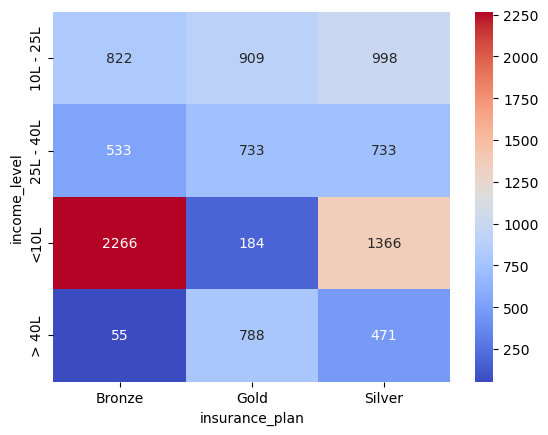

In [96]:
sns.heatmap(data=crosstab, annot=True,cmap='coolwarm', fmt='d')

In [97]:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}
df3[['disease1','disease2']] = df3['medical_history'].str.split("&", expand=True).apply(lambda x: x.str.lower())

df3['disease1'] = df3['disease1'].fillna("none")
df3['disease2'] = df3['disease2'].fillna("none")

df3['total_risk_score'] = 0
for disease in ['disease1','disease2']:
    df3['total_risk_score'] += df3[disease].map(risk_scores)

max_score = df3['total_risk_score'].max()
min_score = df3['total_risk_score'].min()

df3['normalized_risk_score'] = (df3['total_risk_score'] - min_score) / (max_score - min_score)


In [98]:
def calculate_life_style_risk(row):
  physical_activity_risk_score = {
     "High": 0,
        "Medium": 1,
        "Low": 4
  }
  stress_risk_score = {
        "High": 4,
        "Medium": 1,
        "Low": 0
    }
  life_style_risk = physical_activity_risk_score[row['physical_activity']]+stress_risk_score[row['stress_level']]
  return life_style_risk

df3['lifestyle_risk_score'] = df3.apply(calculate_life_style_risk,axis=1)

df3.head(2)


,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score,lifestyle_risk_score
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944,high blood pressure,none,6.0,0.75,2
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108,no disease,none,0.0,0.00,8


<Axes: xlabel='lifestyle_risk_score', ylabel='Count'>

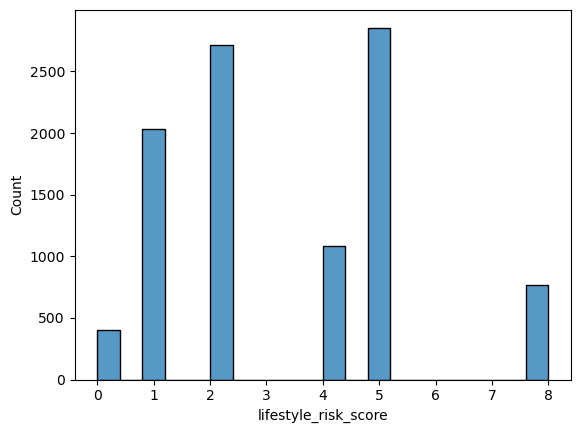

In [99]:
sns.histplot(df3.lifestyle_risk_score,bins=20)

In [100]:
df2.head()

,age,gender,region,marital_status,physical_activity,stress_level,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,56,Female,Southeast,Unmarried,Medium,Medium,2,Normal,No Smoking,Self-Employed,25L - 40L,37,High blood pressure,Gold,27944
1,38,Female,Northeast,Married,Low,High,5,Overweight,Occasional,Freelancer,10L - 25L,10,No Disease,Silver,21108
2,18,Female,Southwest,Unmarried,Medium,High,0,Normal,No Smoking,Freelancer,<10L,9,No Disease,Bronze,8459
3,55,Male,Northeast,Married,High,Medium,3,Overweight,Occasional,Salaried,<10L,9,Thyroid,Silver,21685
4,22,Male,Southeast,Unmarried,Medium,High,2,Normal,Regular,Self-Employed,10L - 25L,13,High blood pressure & Heart disease,Bronze,15984


In [101]:
df3['insurance_plan'] = df3['insurance_plan'].map({'Bronze': 1, 'Silver': 2, 'Gold': 3})
df3.insurance_plan.unique()

array([3, 2, 1])

In [102]:
df3.income_level.unique()

array(['25L - 40L', '10L - 25L', '<10L', '> 40L'], dtype=object)

In [103]:

df3['income_level'] = df3['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

In [104]:
nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df4 = pd.get_dummies(df3,columns=nominal_cols,drop_first=True,dtype=int)
df4.head()

,age,physical_activity,stress_level,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,Medium,Medium,2,3,37,High blood pressure,3,27944,high blood pressure,...,1,0,1,0,0,0,0,0,0,1
1,38,Low,High,5,2,10,No Disease,2,21108,no disease,...,0,0,0,0,1,0,1,0,0,0
2,18,Medium,High,0,1,9,No Disease,1,8459,no disease,...,0,1,1,0,0,0,0,0,0,0
3,55,High,Medium,3,1,9,Thyroid,2,21685,thyroid,...,0,0,0,0,1,0,1,0,1,0
4,22,Medium,High,2,2,13,High blood pressure & Heart disease,1,15984,high blood pressure,...,1,0,1,0,0,0,0,1,0,1


In [105]:
df4.info

<bound method DataFrame.info of       age physical_activity stress_level  number_of_dependants  income_level  \
0      56            Medium       Medium                     2             3   
1      38               Low         High                     5             2   
2      18            Medium         High                     0             1   
3      55              High       Medium                     3             1   
4      22            Medium         High                     2             2   
...   ...               ...          ...                   ...           ...   
9995   31            Medium       Medium                     5             2   
9996   24              High       Medium                     0             3   
9997   18            Medium         High                     0             1   
9998   28              High          Low                     0             3   
9999   33              High         High                     3             1   

      i

In [106]:
df5 = df4.drop(['medical_history','disease1', 'disease2', 'total_risk_score','physical_activity','stress_level'], axis=1)
df5.head(3)


,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,lifestyle_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,56,2,3,37,3,27944,0.75,2,0,0,1,0,1,0,0,0,0,0,0,1
1,38,5,2,10,2,21108,0.00,8,0,0,0,0,0,0,1,0,1,0,0,0
2,18,0,1,9,1,8459,0.00,5,0,0,0,1,1,0,0,0,0,0,0,0


### Calculate VIF for Multicolinearity

In [107]:
df5.columns

Index(['age', 'number_of_dependants', 'income_level', 'income_lakhs',
       'insurance_plan', 'annual_premium_amount', 'normalized_risk_score',
       'lifestyle_risk_score', 'gender_Male', 'region_Northwest',
       'region_Southeast', 'region_Southwest', 'marital_status_Unmarried',
       'bmi_category_Obesity', 'bmi_category_Overweight',
       'bmi_category_Underweight', 'smoking_status_Occasional',
       'smoking_status_Regular', 'employment_status_Salaried',
       'employment_status_Self-Employed'],
      dtype='object')

<Axes: >

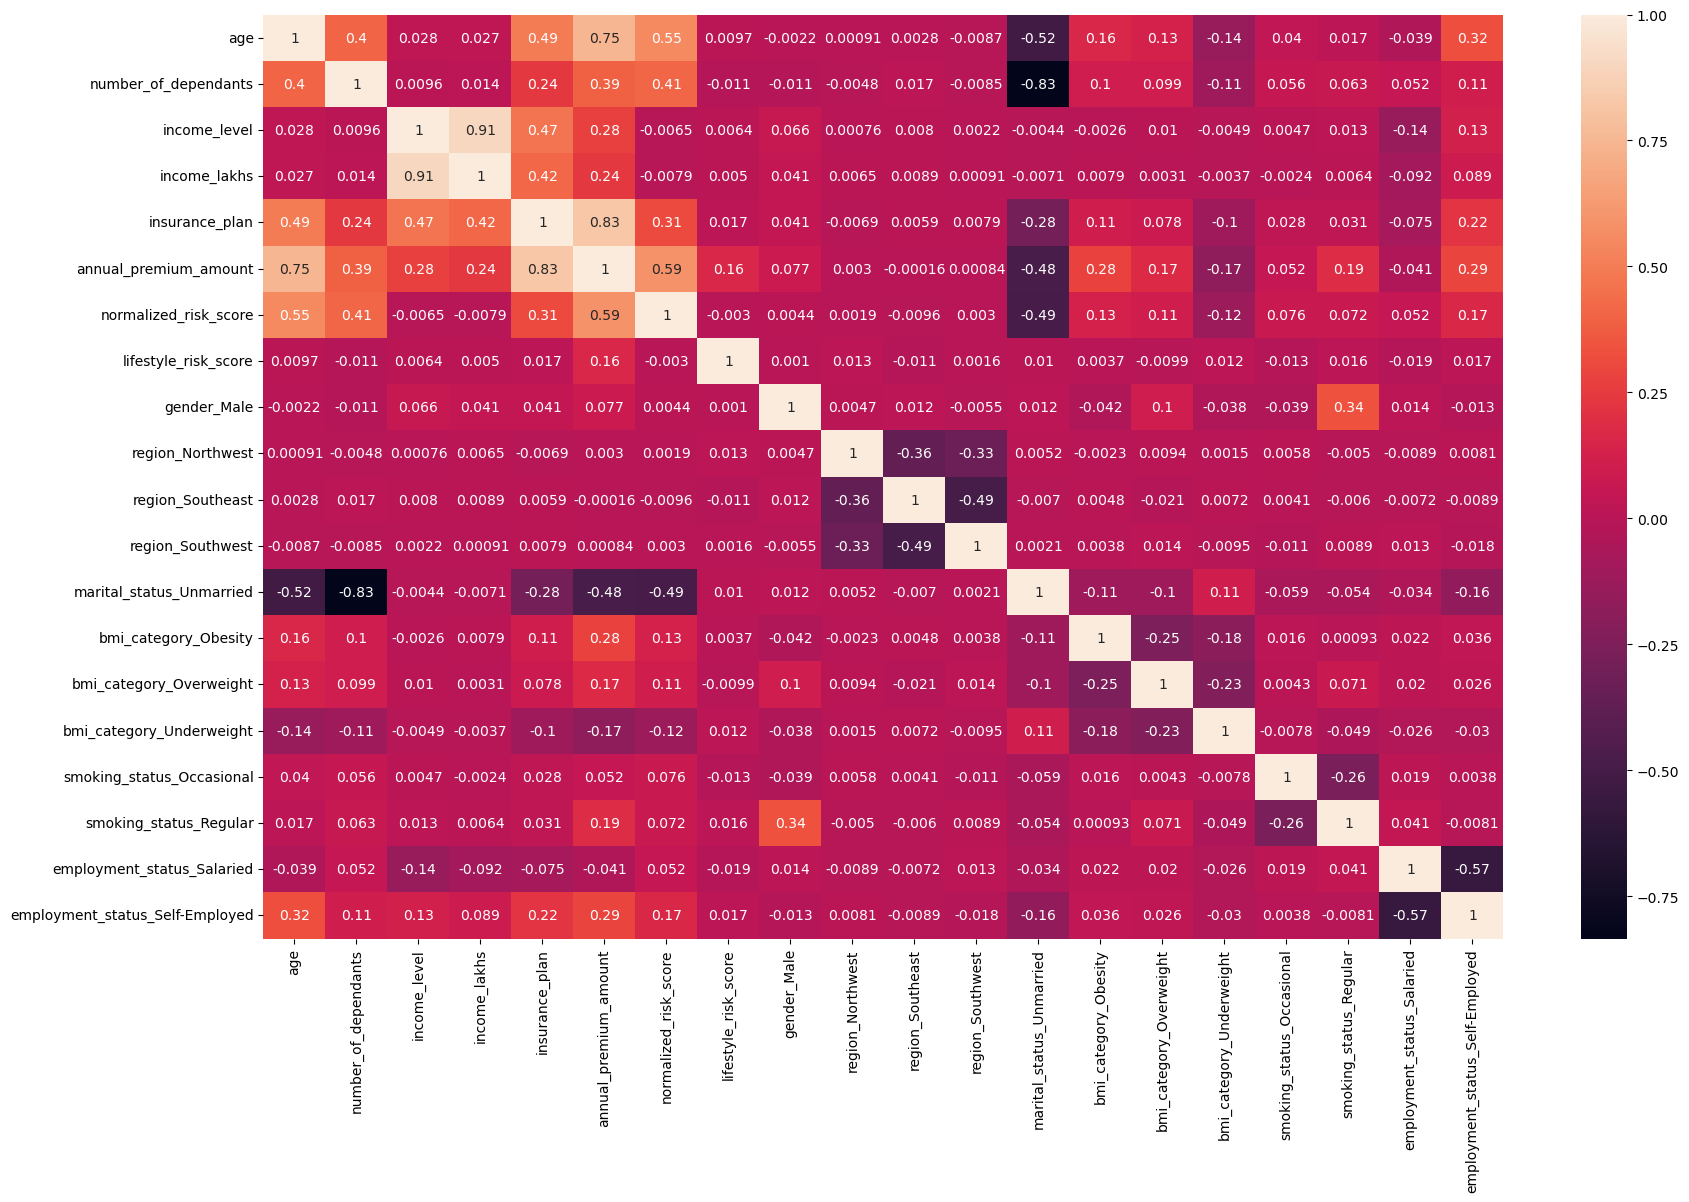

In [108]:
cm = df5.corr()
plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)

In [109]:
from sklearn.preprocessing import MinMaxScaler
X = df5.drop('annual_premium_amount', axis='columns')
y = df5['annual_premium_amount']
cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan', 'lifestyle_risk_score']
scaler = MinMaxScaler()
X[cols_to_scale] = scaler.fit_transform(df5[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,normalized_risk_score,lifestyle_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,8882.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000
mean,0.366014,0.383993,0.360756,0.219027,0.446135,0.461101,0.408349,0.401298,0.194664,0.353013,0.306452,0.437716,0.167985,0.240414,0.141712,0.150030,0.278657,0.420065,0.308176
std,0.258820,0.300605,0.352198,0.226801,0.395765,0.373017,0.268302,0.490186,0.395962,0.477931,0.461043,0.496131,0.373872,0.427356,0.348773,0.357119,0.448361,0.493594,0.461763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.111111,0.000000,0.000000,0.050505,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.351852,0.400000,0.333333,0.151515,0.500000,0.625000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.592593,0.600000,0.666667,0.303030,1.000000,0.750000,0.625000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [110]:
def calculate_vif(data):
    data = data.copy()

    # Replace inf with NaN
    data.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN
    data.dropna(inplace=True)

    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values, i) 
                     for i in range(data.shape[1])]
    return vif_df.sort_values("VIF", ascending=False)

In [111]:
calculate_vif(X)

,Column,VIF
2,income_level,12.490053
3,income_lakhs,10.935752
0,age,6.053661
1,number_of_dependants,5.162732
4,insurance_plan,4.182940
5,normalized_risk_score,3.933647
11,marital_status_Unmarried,3.364198
6,lifestyle_risk_score,3.114725
9,region_Southeast,2.973450
10,region_Southwest,2.678574


In [112]:
calculate_vif(X.drop(columns='income_level',axis=1))

,Column,VIF
0,age,6.002233
1,number_of_dependants,5.149954
4,normalized_risk_score,3.933544
3,insurance_plan,3.926043
10,marital_status_Unmarried,3.341841
5,lifestyle_risk_score,3.114069
8,region_Southeast,2.972820
9,region_Southwest,2.677124
16,employment_status_Salaried,2.504505
2,income_lakhs,2.467634


In [113]:
X_reduced = X.drop('income_level', axis="columns")

In [114]:
# Use the SAME dataframe everywhere
X = X_reduced.copy()
y = y.copy()

# Clean it
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.fillna(X.median())

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=10
)

from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

train_score, test_score


(0.9504073223798071, 0.951104925461429)

In [115]:
y_pred = model_lr.predict(X_test)
mse_lr = mean_squared_error(y_pred,y_test)
rmse_lr = np.sqrt(mse_lr)
print(f" mse error is  {mse_lr} rmse is = {rmse_lr}")


 mse error is  3798304.694298737 rmse is = 1948.9239837147927


In [116]:
np.set_printoptions(suppress=True,precision=6)
model_lr.coef_

array([ 9932.736935,  -568.880138,  -658.990639, 13292.001927,
        4843.263842,  4676.802241,     0.14192 ,   182.596325,
          95.251845,    22.016713,  -821.395112,  4121.132681,
        2161.301378,   417.829103,  1178.237635,  3088.816643,
          -0.00795 ,   378.081525])

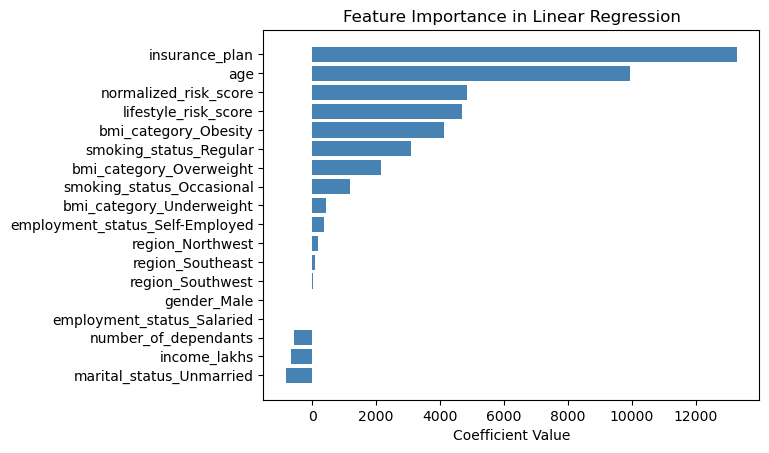

In [117]:
feature_importance = model_lr.coef_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])
coef_df = coef_df.sort_values(by='Coefficients',ascending=True)
plt.Figure(figsize=(18,6))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.show()

In [118]:
from xgboost import XGBRegressor
model_xgb = XGBRegressor(n_estimators=20, max_depth=3)
model_xgb.fit(X_train, y_train)
model_xgb.score(X_test,y_test)

0.9829246401786804

In [119]:
y_pred = model_xgb.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = np.sqrt(mse_lr)
print("XGBoost Regression ==> MSE: ", mse_lr, "RMSE: ", rmse_lr)

XGBoost Regression ==> MSE:  1326463.25 RMSE:  1151.7218631249473


In [120]:
model_xgb = XGBRegressor()
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}
random_search = RandomizedSearchCV(model_xgb, param_grid, n_iter=10, cv=3, scoring='r2', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
random_search.best_score_

np.float64(0.9858293533325195)

In [121]:
y_pred

array([11427.741, 11267.549, 16738.713, ..., 24066.465,  7764.361,
        9580.64 ], dtype=float32)

In [122]:
random_search.best_params_

{'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.1}

In [123]:
best_model = random_search.best_estimator_

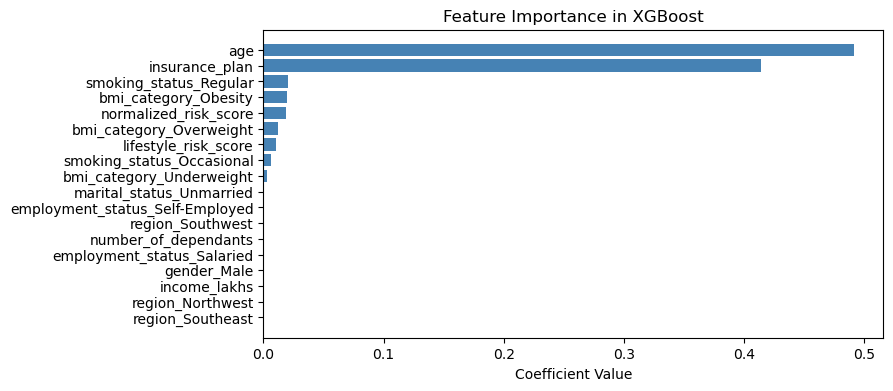

In [124]:
feature_importance = best_model.feature_importances_

# Create a DataFrame for easier handling
coef_df = pd.DataFrame(feature_importance, index=X_train.columns, columns=['Coefficients'])

# Sort the coefficients for better visualization
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Plotting
plt.figure(figsize=(8, 4))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in XGBoost')
plt.show()

In [125]:
y_pred = best_model.predict(X_test)

residuals = y_pred - y_test
residuals_pct = (residuals / y_test) * 100

results_df = pd.DataFrame({
    'actual': y_test, 
    'predicted': y_pred, 
    'diff': residuals, 
    'diff_pct': residuals_pct
})
results_df.head()

,actual,predicted,diff,diff_pct
3021,13354,12071.705078,-1282.294922,-9.602328
6049,10701,11616.187500,915.187500,8.552355
6146,15146,16474.087891,1328.087891,8.768572
6418,8743,9136.093750,393.093750,4.496097
1537,27887,26060.154297,-1826.845703,-6.550886


<Axes: xlabel='diff_pct', ylabel='Count'>

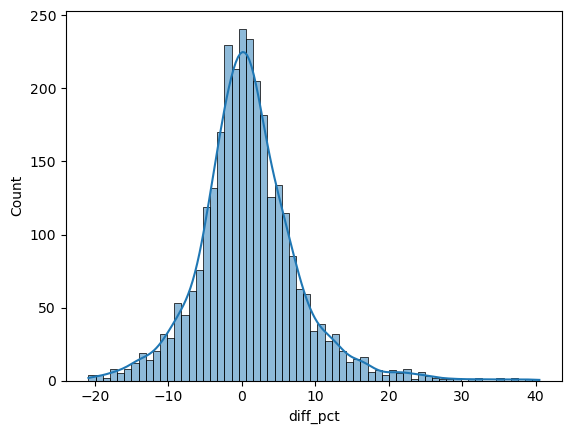

In [126]:
sns.histplot(results_df['diff_pct'],kde=True)

In [127]:
X_test.shape

(2958, 18)

In [128]:
extreme_threshold = 10
extreme_threshold_result = results_df[np.abs(results_df['diff_pct'])> extreme_threshold]
extreme_threshold_result.shape

prt = (extreme_threshold_result.shape[0])*100/X_test.shape[0]
prt

12.508451656524679